In [1]:
import os
import datetime
import backtrader as bt
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize']=[15, 10]

In [2]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

In [3]:
class MyStrat(bt.Strategy):
    params = dict(
        period=20,
        devfactor=2
    )
    
    def __init__(self):
        self.bb = bt.indicators.BollingerBands(period=self.p.period, devfactor=self.p.devfactor)
        self.slope = self.bb

    def next(self):
        self.positive_slope = (self.bb.mid[0] - self.bb.mid[-1]) > 0
        if not self.position:
            
            #if trend is positive and price below bb mid line, go all in
            if self.data.close[0] <= self.bb.mid and self.positive_slope:
                self.order_target_percent(target=1)
            # if trend is negative and price above bb mid line short
            elif self.data.close[0] >= self.bb.mid and not self.positive_slope:
                self.order_target_percent(target=-1)
        else:
            is_short = self.position.size < 0
            is_long = self.position.size > 0
            if is_short:
                # if trend turns positive or price goes below bb bottom line close position
                if self.data.close[0] < self.bb.bot or self.positive_slope:
                    self.close()
            elif is_long:
                # if trend turns negative or price goes above bb top line, close position
                if self.data.close[0] > self.bb.top or not self.positive_slope:
                    self.close()
                    
    def stop(self):
        self.thevalue = self.broker.get_value()
            

In [4]:
cerebro = bt.Cerebro()

cerebro.optstrategy(MyStrat, period=range(10, 50), devfactor=[1, 1.5, 2], )

fromdate, todate = datetime.datetime(2019, 6, 15), datetime.datetime(2020, 6, 19)

dn = 'ETF/spy.csv'
data = bt.feeds.GenericCSVData(
    dataname=dn,
    fromdate=fromdate,
    todate=todate,
    nullvalue=0.0,
    dtformat=('%m/%d/%Y'),
    datetime=0,
    high=3,
    low=4,
    open=1,
    close=2,
    volume=5,
    openinterest=-1
)
cerebro.adddata(data)
cerebro.broker.setcash(10000)
cerebro.broker.set_coc(True)

results = cerebro.run(
    maxcpus=1, # set maxcpus to 1 or else jupyter notebook will hang
    optreturn=False #set optreturn to False to get full strategies returned
) 

In [5]:
st0 = [s[0] for s in results]

In [6]:
vals = {(s.p.period, s.p.devfactor): s.thevalue for s in st0}
max_params = max(vals, key=vals.get)
max_params, vals[max_params]
# period of 16 and devfactor of 2 achieved best results

((16, 2), 11497.16)

In [7]:
# probably not a great strat to begin with
np.mean(list(vals.values())), np.median(list(vals.values()))

(9854.191749999998, 9815.890000000001)

In [8]:
import seaborn as sns

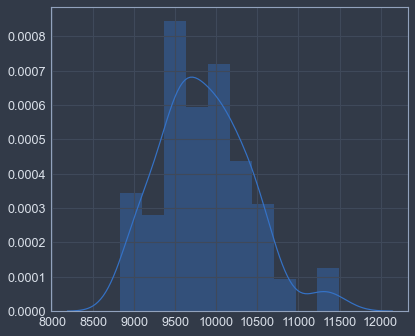

In [9]:
sns.distplot(list(vals.values()))